In [2]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
from config import configuration
config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [414]:
gg = glob.glob('/local/scratch_2/jls/virac_classifier/binary/v2/binary_*.pkl')
def loader(g):
    with open(g, 'rb') as f:
        binary = pickle.load(f)
    totals = binary.training_set['detailed_var_class'].value_counts()
    misclassified = binary.training_set['detailed_var_class'][binary.training_set['class']=='CONST'].value_counts()
    
    var_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&(binary.training_set['class']=='VAR')],
                              range=[11,17],bins=50)
    var_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&(binary.training_set['class']=='CONST')],
                              range=[11,17],bins=50)
    const_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&(binary.training_set['class']=='CONST')],
                              range=[11,17],bins=50)
    const_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&(binary.training_set['class']=='VAR')],
                              range=[11,17],bins=50)
    
    return binary.feature_importance, binary.cm, binary.cr, totals, misclassified, .5*(b[1:]+b[:-1]), var_var, var_const, const_const, const_var
full_set = [loader(g) for g in gg]

In [415]:
print(len(full_set))

166


In [416]:
const_CR = pd.DataFrame.from_dict([f[2]['CONST'] for f in full_set]).mean()
print(const_CR)
var_CR = pd.DataFrame.from_dict([f[2]['VAR'] for f in full_set]).mean()
print(var_CR)

f1-score          0.862764
precision         0.862567
recall            0.863933
support      313315.433735
dtype: float64
f1-score          0.901694
precision         0.905889
recall            0.897785
support      398911.632530
dtype: float64


In [417]:
CM=np.sum([f[1] for f in full_set],axis=0)/np.sum([f[1] for f in full_set],axis=(0,1))
print(CM)

[[0.87144143 0.09391579]
 [0.12855857 0.90608421]]


Text(0.5, 0, 'Feature importance')

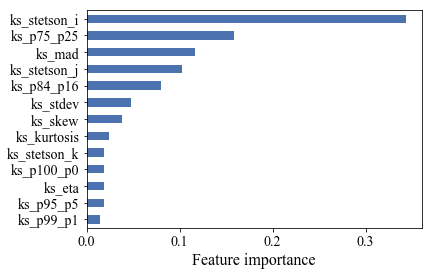

In [418]:
df=pd.DataFrame.from_dict([f[0] for f in full_set]).mean()
df.nsmallest(20).plot(kind='barh')
plt.xlabel('Feature importance')

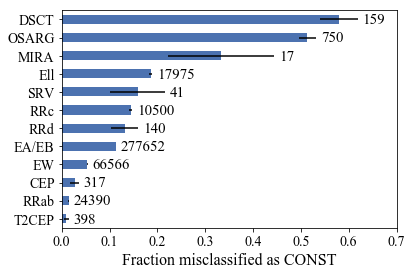

In [419]:
total_classes = pd.DataFrame.from_dict([f[3] for f in full_set])
misclassified = pd.DataFrame.from_dict([f[4] for f in full_set])
rates = (misclassified/total_classes).mean().nsmallest(20)[:-1]
C=total_classes.mean().to_dict()
Xerr = [np.sqrt(R*(1-R)/C[d]) for R,d in zip(rates.values,rates.keys())]
rates.plot(kind='barh', xerr=Xerr)
plt.xlabel(r'Fraction misclassified as CONST')
plt.xlim(0.,0.7)
[plt.annotate('%i'%C[c],(d+0.01+x,i-0.25),fontsize=15) 
 for i,(d,c,x) in enumerate(zip(rates.values,rates.keys(),Xerr))];

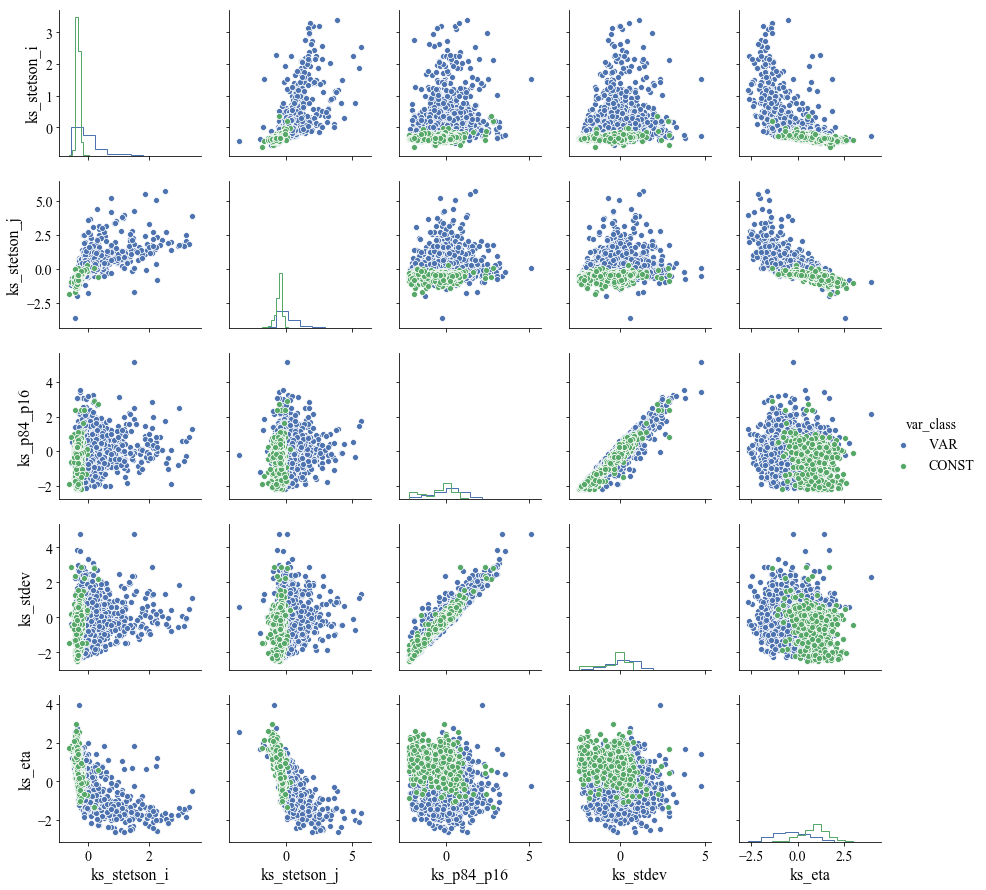

In [420]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_11.pkl', 'rb') as f:
    binary = pickle.load(f)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_stdev','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

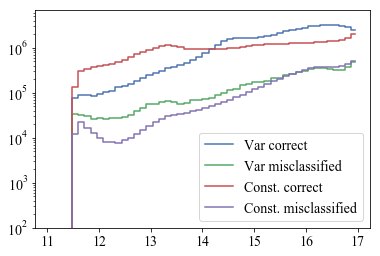

In [421]:
plt.step(full_set[0][5], np.sum([f[6] for f in full_set], axis=0), where='mid', label='Var correct')
plt.step(full_set[0][5], np.sum([f[7] for f in full_set], axis=0), where='mid', label='Var misclassified')
plt.step(full_set[0][5], np.sum([f[8] for f in full_set], axis=0), where='mid', label='Const. correct')
plt.step(full_set[0][5], np.sum([f[9] for f in full_set], axis=0), where='mid', label='Const. misclassified')

plt.semilogy()
plt.ylim(100.,)
plt.legend()

/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


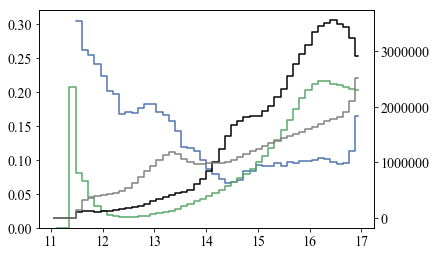

In [422]:
plt.step(full_set[0][5], np.sum([f[7] for f in full_set], axis=0)/(np.sum([f[6] for f in full_set], axis=0)+np.sum([f[7] for f in full_set], axis=0)), 
         where='mid', label='Var correct')

plt.step(full_set[0][5], np.sum([f[9] for f in full_set], axis=0)/(np.sum([f[8] for f in full_set], axis=0)+np.sum([f[9] for f in full_set], axis=0)), 
         where='mid', label='Var correct')

plt.ylim(0.,)

plt.twinx()

plt.step(full_set[0][5], (np.sum([f[6] for f in full_set], axis=0)+np.sum([f[7] for f in full_set], axis=0)), 
         where='mid', label='Var correct',color='k')
plt.step(full_set[0][5], (np.sum([f[8] for f in full_set], axis=0)+np.sum([f[9] for f in full_set], axis=0)), 
         where='mid', label='Var correct',color='gray')

In [423]:
from initial_classif.trainset.variable_training_sets import load_all_variable_stars
v = load_all_variable_stars(config)

In [446]:
from initial_classif.trainset.gaia_extraction import grab_virac_gaia_region_with_stats
g = grab_virac_gaia_region_with_stats(1.,1.,2.,2.,config)

In [ ]:
f,a=plt.subplots(1,3,figsize=[15.,5.],sharey=True)
plt.sca(a[0])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[:4]];
plt.legend()
plt.semilogy()
plt.sca(a[1])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[4:8]];
plt.legend()
plt.semilogy()
plt.sca(a[2])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[8:]];
plt.legend()
plt.semilogy()
for ii in a:
    plt.sca(ii)
    plt.hist(np.log10(g['ks_p84_p16']), bins=40,histtype='step',
              range=[-2,0.5],normed=True,lw=2,label='CONST',color='k');

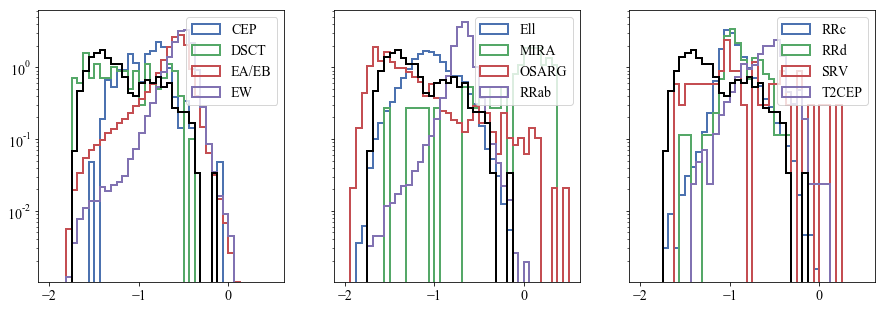

In [449]:
f,a=plt.subplots(1,3,figsize=[15.,5.],sharey=True)
plt.sca(a[0])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[:4]];
plt.legend()
plt.semilogy()
plt.sca(a[1])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[4:8]];
plt.legend()
plt.semilogy()
plt.sca(a[2])
[plt.hist(np.log10(v['ks_p84_p16'])[v['var_class']==c],bins=40,histtype='step',
          range=[-2,0.5],normed=True,lw=2,label=c) for c in np.unique(v['var_class'])[8:]];
plt.legend()
plt.semilogy()
for ii in a:
    plt.sca(ii)
    plt.hist(np.log10(g['ks_p84_p16']), bins=40,histtype='step',
              range=[-2,0.5],normed=True,lw=2,label='CONST',color='k');

### Test

with blah/error columns

[[15698  2237]
 [ 1927 17961]]


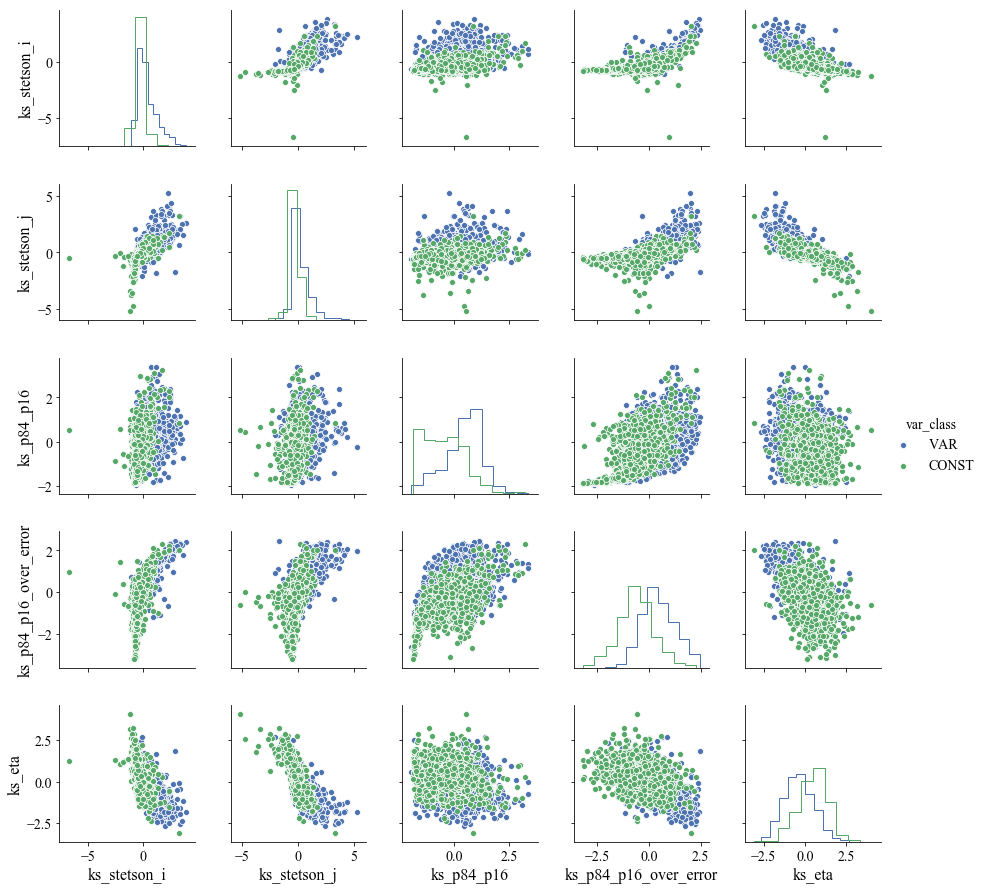

In [7]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

without blah/error columns

[[15597  2338]
 [ 2254 17634]]


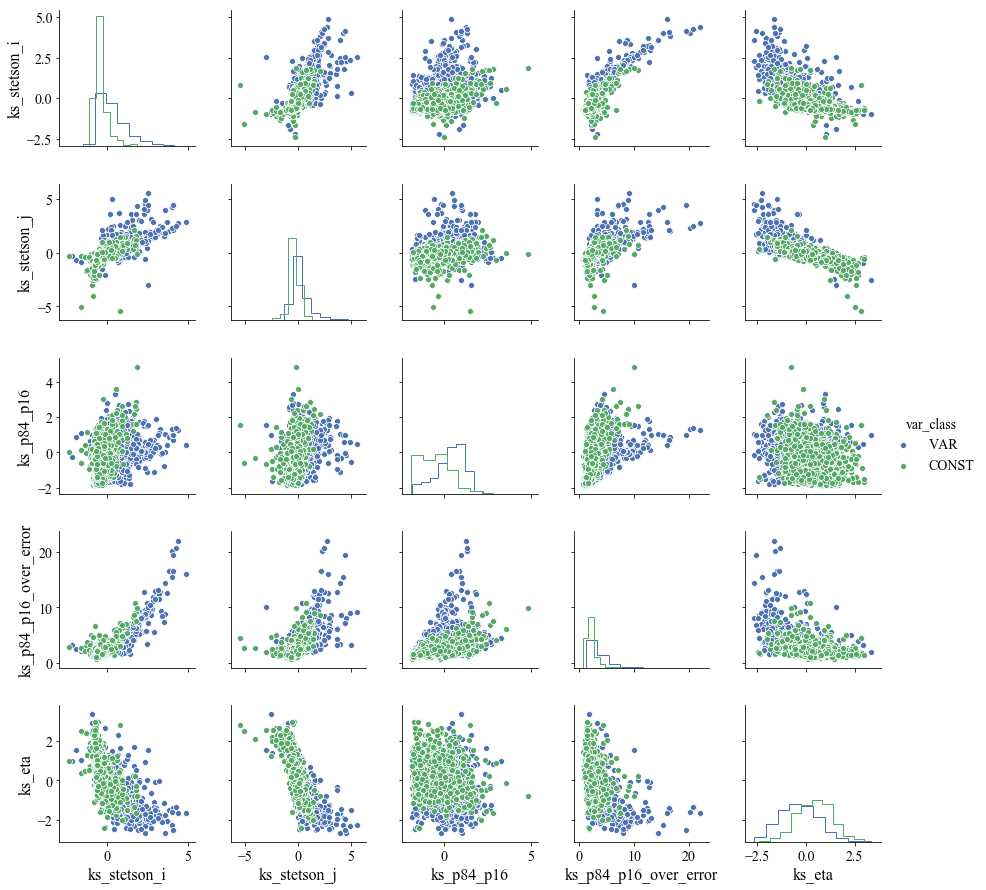

In [8]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

without OSARG/DSCT

[[15741  2194]
 [ 1929 17899]]


/data/jls/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


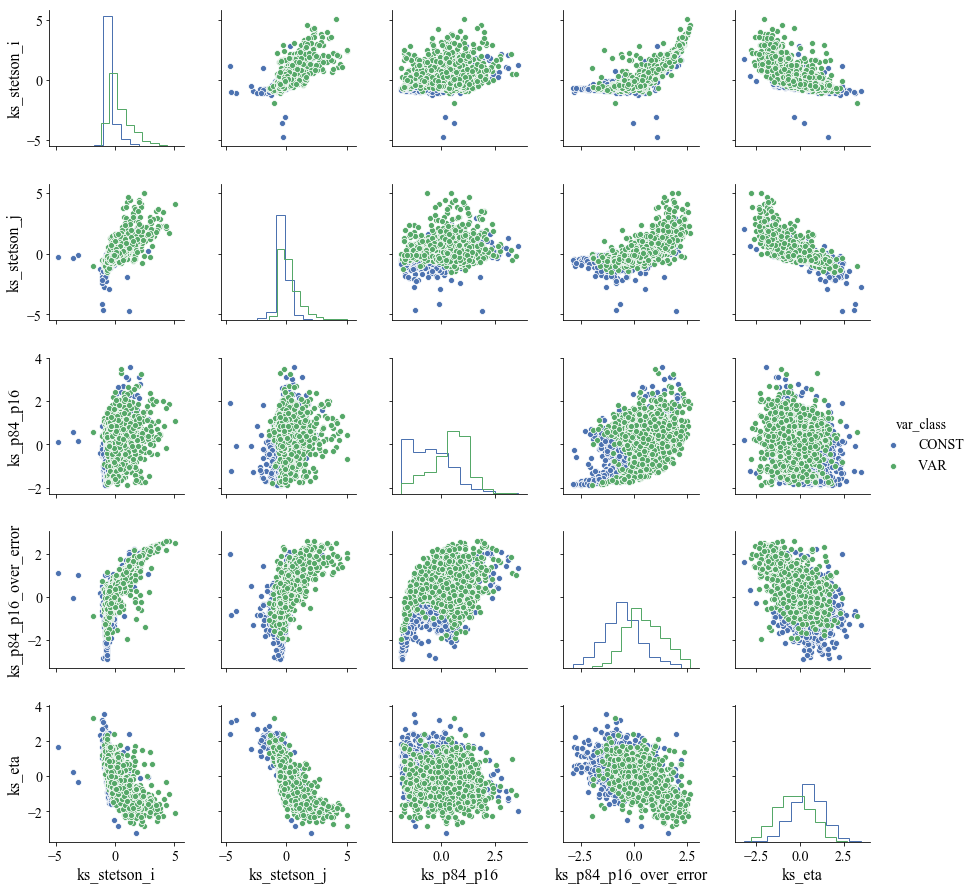

In [15]:
import seaborn as sns
with open('/local/scratch_2/jls/virac_classifier/binary/v2/binary_0_test.pkl', 'rb') as f:
    binary = pickle.load(f)
print(binary.cm)
df = binary.training_set[['ks_stetson_i','ks_stetson_j','ks_p84_p16',
                          'ks_p84_p16_over_error','ks_eta','detailed_var_class','var_class']].sample(2000)
# df = df[np.isin(df['detailed_var_class'],['CONST','EA/EB'])]
sns.pairplot(df, hue='var_class',diag_kind='hist',diag_kws={'histtype':'step','normed':True})

## Second stage training

In [33]:
from initial_classif.trainset.variable_training_sets import load_all_variable_stars
from initial_classif.trainset.gaia_extraction import generate_gaia_training_set_random
def generate_secondstage_training_for_leigh():
    config['test']='0'
    variable_stars = load_all_variable_stars(config)
    constant_data = generate_gaia_training_set_random(len(variable_stars)//10, config,
                                                      np.float64(config['gaia_percentile']),
                                                      600000)
    constant_data['var_class']='CONST'
    trainset = pd.concat([variable_stars, constant_data], axis=0, sort=False).reset_index(drop=True)
    config['test']='1'
    return trainset

In [ ]:
trainset = generate_secondstage_training_for_leigh()

In [36]:
trainset['var_class'].value_counts()

EA/EB    281477
EW        67924
CONST     37593
RRab      24837
Ell       18055
RRc       10519
OSARG       775
T2CEP       673
CEP         333
DSCT        160
RRd         141
MIRA         60
SRV          54
Name: var_class, dtype: int64

In [162]:
trainset[trainset['sourceid'].duplicated()]['g_amp']

405159   -2.220927
411903   -2.025333
419648   -1.336664
423101   -1.913778
Name: g_amp, dtype: float64

[]

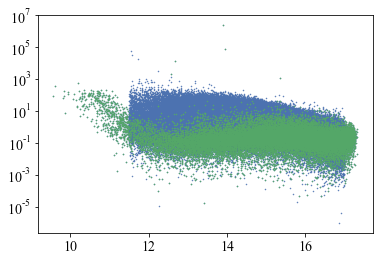

In [181]:
plt.plot(trainset['ks_b_ivw_mean_mag'],trainset['ks_stetson_i'],'.',ms=1);
plt.plot(trainset['ks_b_ivw_mean_mag'][trainset['var_class']=='CONST'],
         trainset['ks_stetson_i'][trainset['var_class']=='CONST'],'.',ms=1);

plt.semilogy()

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[]

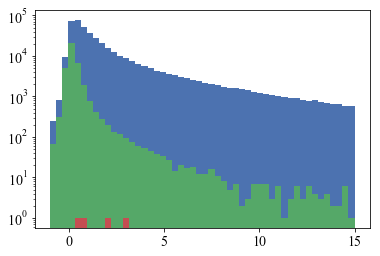

In [177]:
plt.hist(trainset['ks_stetson_i'],bins=50,range=[-1,15]);
plt.hist(trainset['ks_stetson_i'][trainset['var_class']=='CONST'],bins=50,range=[-1,15]);
plt.hist(trainset['ks_stetson_i'][trainset['sourceid'].duplicated()],bins=50,range=[-1,15]);
plt.semilogy()

In [53]:
import sqlutilpy as sqlutil
import sys
sys.path.append('../../../../')
from virac_utils import wsdb_kwargs
del wsdb_kwargs['asDict']
sqlutil.upload('jason_sanders.variable_training_set_virac2_stats_with_const_sourceid',
               (trainset['sourceid'].values, ),
               ['virac_id',], **wsdb_kwargs)

In [ ]:
cols = ['']

In [70]:
import h5py
with h5py.File("/data/jls/virac/n512_2318830.hdf5", "r") as f:
    print(f['sourceList']['h_b_ivw_mean_mag'][4])
    print(f['sourceList']['sourceid'][4])
    print(f['variabilityIndices'].keys())

17.53873
9274333000004
<KeysViewHDF5 ['ks_epoch_first', 'ks_epoch_last', 'ks_eta', 'ks_eta_e', 'ks_kurtosis', 'ks_mad', 'ks_mean', 'ks_n_epochs', 'ks_ncross_0_mad', 'ks_ncross_0_std', 'ks_ncross_10_mad', 'ks_ncross_10_std', 'ks_ncross_1_mad', 'ks_ncross_1_std', 'ks_ncross_2_mad', 'ks_ncross_2_std', 'ks_ncross_3_mad', 'ks_ncross_3_std', 'ks_ncross_5_mad', 'ks_ncross_5_std', 'ks_ncross_m10_mad', 'ks_ncross_m10_std', 'ks_ncross_m1_mad', 'ks_ncross_m1_std', 'ks_ncross_m2_mad', 'ks_ncross_m2_std', 'ks_ncross_m3_mad', 'ks_ncross_m3_std', 'ks_ncross_m5_mad', 'ks_ncross_m5_std', 'ks_p0', 'ks_p1', 'ks_p100', 'ks_p16', 'ks_p2', 'ks_p25', 'ks_p32', 'ks_p4', 'ks_p5', 'ks_p50', 'ks_p68', 'ks_p75', 'ks_p8', 'ks_p84', 'ks_p92', 'ks_p95', 'ks_p96', 'ks_p98', 'ks_p99', 'ks_pspl_count_range_0te_1te_a', 'ks_pspl_count_range_1te_0te_b', 'ks_pspl_count_range_1te_2te_a', 'ks_pspl_count_range_2te_1te_b', 'ks_pspl_count_range_2te_3te_a', 'ks_pspl_count_range_3te_2te_b', 'ks_pspl_count_range_3te_inf_a', 'ks_ps

In [80]:
from interface_utils.light_curve_loader import lightcurve_loader
l = lightcurve_loader()

In [81]:
df=l.get_data_table_per_file(2318830, 512, config)

In [133]:
grid = pd.read_pickle('/local/scratch_2/jls/virac_classifier/binary/v2/grid_test.pkl')

In [134]:
grid = pd.concat([grid, pd.DataFrame.from_dict({'index':[2],'l':[2.783411],'b':[-0.054603]})])

In [143]:
df['l'][0]=10.

In [144]:
cells = np.abs(df['l'][:,np.newaxis]-grid['l'][np.newaxis,:])<.5*np.float64(config['sizel'])
cells &= np.abs(df['b'][:,np.newaxis]-grid['b'][np.newaxis,:])<.5*np.float64(config['sizeb'])

In [148]:
np.argwhere(cells)

array([[    1,     0],
       [    2,     0],
       [    3,     0],
       ...,
       [30708,     0],
       [30709,     0],
       [30710,     0]])

In [146]:
len(np.argwhere(cells)), len(df)*2

(30710, 61422)

In [127]:
l.healpix_grid['index'][l.healpix_grid['hpx']==2318830]

5374    7380776
Name: index, dtype: int64

In [154]:
np.arange(-65.6428571434, -9.9,1.4642857143)

array([-65.64285714, -64.17857143, -62.71428571, -61.25      ,
       -59.78571429, -58.32142857, -56.85714286, -55.39285714,
       -53.92857143, -52.46428571, -51.        , -49.53571429,
       -48.07142857, -46.60714286, -45.14285714, -43.67857143,
       -42.21428571, -40.75      , -39.28571429, -37.82142857,
       -36.35714286, -34.89285714, -33.42857143, -31.96428571,
       -30.5       , -29.03571429, -27.57142857, -26.10714286,
       -24.64285714, -23.17857143, -21.71428571, -20.25      ,
       -18.78571429, -17.32142857, -15.85714286, -14.39285714,
       -12.92857143, -11.46428571, -10.        ])